### This notebook estimates the maximum number of electrons per pixel the spaceX satellites would produce.

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import lsst.syseng.throughputs as st
from lsst.sims.photUtils import PhotometricParameters, Sed
import galsim
import matplotlib.pyplot as plt

### We use Eq (6) in LSE-40. With the baseline system as defined by syseng_throughput (including hardware & atmosphere), We can easily map a source magnitude to a source count. 

In [2]:
# full_well for a 30s visit, in e-
full_well = 150e3  #typical for e2v sensors. ITL is typically 200k. We try to be conservative and use the smaller.
full_well2 = 100e3  #some sensors can be as low as 100K e-.
bias_offset = 45e3
bias_offset_subtract = 0 #According to Steve R. and Aaron R., this should not be a factor

## We first determine what fraction of the flux will be in the center/brightest pixel
#### A satellite moves at 0.5 deg per sec. It is 4m wide and 550km high.

In [3]:
fwhm_extended = 4/550e3/np.pi*180*3600
#fwhm = np.sqrt(fwhm_extended**2+.4**2+fwhms**2) #need Tony to confirm whether we should use this fwhm_extended as the total
fwhm = fwhm_extended
print('FWHM = %.2f arcsec'%fwhm)

FWHM = 1.50 arcsec


In [4]:
#Assume it moves along pixel grid. The time its image center moves from one pixel center to the next is dt
dt = 0.2/(0.5*3600) # in seconds

#### Approximate it as a source which appears at one pixel center for dt, then disappears from there, and instantly appears at the next pixel center for dt. During each dt, the source deposit a flux profile that is a Gaussian with FWHM of 1.5 arcsec.
So we are just overlapping Gaussians whose centers are 0.2 arcsec apart. Considering that the FWHM is much larger than pixel size, the top of the Gaussians are pretty flat. So this should be a pretty good approximation.
This slightly overestimates the flux, because having the Gaussian moving across the pixel in dt would yield a smaller flux for the pixel, compared to when the center of the Gaussian is overlapped with the pixel center during dt.

0.12473681564774915


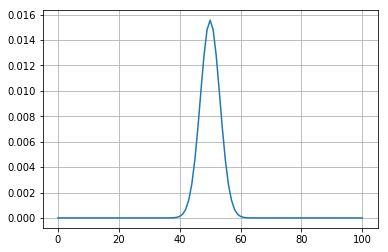

In [5]:
stamp_size = 101
pixel_scale = 0.2
psf = galsim.Gaussian(fwhm=fwhm)
img = galsim.ImageD(stamp_size, stamp_size, scale=pixel_scale)
psf = psf.withFlux(1) #unit flux
psf.drawImage(image=img)
ratio = sum(img.array[50,:])/np.sum(img.array)
plt.plot(img.array[50,:])
print(ratio)
plt.grid()

In [6]:
#what if the trail is 45 deg to the pixel grid?
# dt will be 1.414 time longer, would that give a larger ratio?
print(sum(np.diag(img.array))*1.414)
# it is the same. Bingo. That is it.

0.1247186070983438


### Baseline LSST system, as defined in syseng_throughput

In [7]:
defaultDirs = st.setDefaultDirs()
hardware, system = st.buildHardwareAndSystem(defaultDirs)

### Default photometric parameters, as used in standard m5 calculations

In [8]:
exptime=15 
nexp=2
readnoise=8.8 
othernoise=0 
darkcurrent=0.2
effarea=np.pi*(6.423/2*100)**2
X=1.0

# PhotometricParameters object for standard m5 calculations.
photParams_std = PhotometricParameters(exptime=exptime, nexp=nexp,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)

### Let's make sure we can reproduce standard m5 results

In [9]:
m5 = st.makeM5(hardware, system, darksky=None, 
                      exptime=exptime, nexp=nexp, readnoise=readnoise, othernoise=othernoise, darkcurrent=darkcurrent,
                      effarea=effarea, X=1.0)

In [10]:
m5

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.92,0.80824,22.960730,80.840573,27.009181,0.035837,0.057997,0.522669,0.038185,23.165597,0.576230,0.362984,23.849238,550.932990,23.9,23.4
g,0.87,0.76714,22.257758,411.094794,28.399288,0.128938,0.154358,0.195371,0.038743,24.447490,0.176182,0.093056,24.840316,795.628429,25.0,24.6
r,0.83,0.73426,21.196590,818.797145,28.177407,0.105106,0.115690,0.104170,0.038990,24.467511,0.096081,0.047725,24.380855,990.243723,24.7,24.3
i,0.80,0.70960,20.477419,1173.487799,27.879556,0.079889,0.085493,0.073607,0.039101,24.363045,0.068928,0.033121,23.956774,1112.330543,24.0,23.6
z,0.78,0.69316,19.599578,1782.992383,27.481805,0.055384,0.057871,0.047694,0.039235,24.201828,0.046435,0.021447,23.384125,1306.751554,23.3,22.9
y,0.76,0.67672,18.610405,2371.023361,26.687500,0.026648,0.030944,0.162291,0.039311,23.759692,0.035324,0.015804,22.475605,1451.707778,22.1,21.7


### Set up the dataframe

In [11]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
properties = ['SatLim']
d = pd.DataFrame(index=filterlist, columns=properties, dtype='float')

### Calculate the saturation limits

In [12]:
# change exposure to dt
photParams_dt = PhotometricParameters(exptime=dt, nexp=1,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)
key = 'SatLim'
for f in system:
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_dt)

    adu0 = adu*ratio
    #because setFlatSED() assumes a m=0 star
    # we use gain=1.0, so adu = number of e-
    # we also get rid of skycounts from each pixel. This has miminal effect on results
    d[key].loc[f] = np.log10(adu0/(full_well-m5.skyCounts.loc[f]-bias_offset_subtract))/2*5
    # The above can also be obtained this way, 
    # (but flatsource has to be re-initialized for each calculation)
    # Scale fnu so that adu0 is equal to full well.
    #flatsource.fnu = flatsource.fnu * (full_well/adu0)
    #d[key].loc[f] = flatsource.calcMag(system[f])

In [13]:
d.join(m5)

,SatLim,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,1.923919,0.92,0.80824,22.960730,80.840573,27.009181,0.035837,0.057997,0.522669,0.038185,23.165597,0.576230,0.362984,23.849238,550.932990,23.9,23.4
g,3.316420,0.87,0.76714,22.257758,411.094794,28.399288,0.128938,0.154358,0.195371,0.038743,24.447490,0.176182,0.093056,24.840316,795.628429,25.0,24.6
r,3.097503,0.83,0.73426,21.196590,818.797145,28.177407,0.105106,0.115690,0.104170,0.038990,24.467511,0.096081,0.047725,24.380855,990.243723,24.7,24.3
i,2.802235,0.80,0.70960,20.477419,1173.487799,27.879556,0.079889,0.085493,0.073607,0.039101,24.363045,0.068928,0.033121,23.956774,1112.330543,24.0,23.6
z,2.408940,0.78,0.69316,19.599578,1782.992383,27.481805,0.055384,0.057871,0.047694,0.039235,24.201828,0.046435,0.021447,23.384125,1306.751554,23.3,22.9
y,1.618951,0.76,0.67672,18.610405,2371.023361,26.687500,0.026648,0.030944,0.162291,0.039311,23.759692,0.035324,0.015804,22.475605,1451.707778,22.1,21.7


#### Double-check: do the same calculation using zero points

In [14]:
d_zp = pd.DataFrame(index=filterlist, columns=properties, dtype='float')
key = 'SatLim'
for f in system:
    #number of electrons we can accomodate for the source in dt sec
    ne = (full_well-m5.skyCounts[f]-bias_offset_subtract)/ratio
    #number of electrons we can accomodate for this source in 1 sec
    ne = ne/dt
    d_zp[key].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))

In [15]:
round(d_zp - d)  #should be idential to above calculations

,SatLim
u,0.0
g,-0.0
r,0.0
i,-0.0
z,-0.0
y,-0.0


### Make peak electron counts vs. mag plot

In [16]:
pRatio = ratio
colors = ['blue', 'green', 'red', '0.75', '0.50', '0.25']
d_plot = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float')

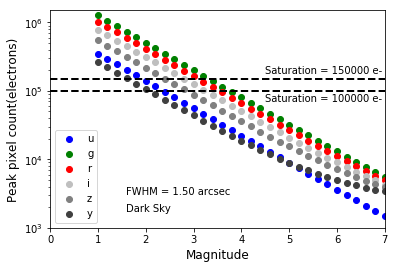

In [17]:
fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_dt)
    adu0 = adu*pRatio #a m=0 start produces this adu0 in the center pixel
    for m in range(31):
        mag = 1 + 0.2 * m
        mags.append(mag)
        npeak = adu0*10**(-mag/2.5)+m5.skyCounts[f]+bias_offset_subtract
        npeaks.append(npeak)
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
    d_plot.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
plt.plot([0,7.0],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([0,7.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.24, "FWHM = %.2f arcsec"%fwhm, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.18, "Dark Sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(0,7.0)
plt.ylim(1e3, 1.5e6)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12);

In [18]:
#check consistency with above calculations.
d_plot.join(d)

,SatLimFromPlot,SatLim
u,2.0,1.923919
g,3.4,3.316420
r,3.2,3.097503
i,3.0,2.802235
z,2.6,2.408940
y,1.8,1.618951


### We can use the zeropoints to do the same calculations and make the same plot

for 5th mag, under dark sky, band u, peak e per pixel = 8900
for 5th mag, under dark sky, band g, peak e per pixel = 32141
for 5th mag, under dark sky, band r, peak e per pixel = 26684
for 5th mag, under dark sky, band i, peak e per pixel = 20833
for 5th mag, under dark sky, band z, peak e per pixel = 15412
for 5th mag, under dark sky, band y, peak e per pixel = 8929


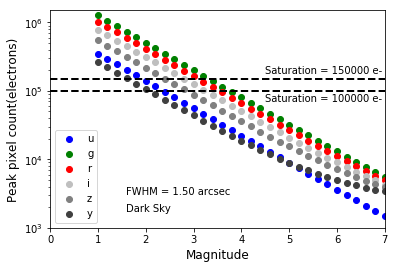

In [19]:
d_plot_zp = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float')
fig, ax = plt.subplots()
peak_e_mag_5 = []
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    for m in range(31):
        mag = 1.0 + 0.2 * m
        mags.append(mag)
        #for a source of mag, how many electrons is produced on detector in a second?
        ne = 10**((m5.Zp_t[f] - mag)/2.5)
        # what about dt seconds
        ne *= dt
        # how many fall into the center pixel? on top of the background and others
        npeak = ne*pRatio+ m5.skyCounts[f]+bias_offset_subtract
        npeaks.append(npeak)
        d_plot_zp.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
        if mag==5.0:
            peak_e_mag_5.append(npeak)
            print('for 5th mag, under dark sky, band %s, peak e per pixel = %.0f'%(f,npeak))
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
plt.plot([0,7.0],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([0,7.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.24, "FWHM = %.2f arcsec"%fwhm, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.18, "Dark Sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(0,7.0)
plt.ylim(1e3, 1.5e6)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12)
plt.savefig('Peak_count_by_band_trail_darkSky.pdf')

In [20]:
round(d_plot - d_plot_zp) #should be identical to calculations using zero points

,SatLimFromPlot
u,0.0
g,0.0
r,0.0
i,0.0
z,0.0
y,0.0


#### Now do the same thing for bright sky. We will only do the calculations using zero points below.

In [21]:
import os
from lsst.utils import getPackageDir
def skyMag2Count(skyMag, f, hardware, photParams):
    '''
    inputs:
        skyMag is the sky magnitude
        f is the filter band
        hardware: an bandpass object as defined in the syseng_throughput package
        photParams: an PhotometricParameters object as defined in the syseng_throughput package
    output:
        skycount in each pixel
    '''
    darksky = Sed()
    darksky.readSED_flambda(os.path.join(getPackageDir('syseng_throughputs'),
                                             'siteProperties', 'darksky.dat'))
    fNorm = darksky.calcFluxNorm(skyMag, hardware)
    darksky.multiplyFluxNorm(fNorm)
    skyCount = (darksky.calcADU(hardware, photParams=photParams)* photParams.platescale**2)
    return fNorm, skyCount

skyBrightMag below is sky brightness at 50 deg from full moon (based on DeCam experience)

Tony wrote :

Even the 
11 yr solar cycle gives 0.5 mag change in v band.  For our immediate 
SpaceX purpose it would be appropriate to generate only two plots, one 
for bright time and one for dark time.  In the mid 2020s we enter solar 
max, so add 0.4 mag in v band to sky.

In [23]:
skyBrightMag = {'u': 17.7, 'g':19.4, 'r':19.7, 'i':19.4, 'z':18.2, 'y':17.7}

In [24]:
skyCounts = {}
for f in system:
    skyCount = 10**((0.4+m5.skyMag[f]-skyBrightMag[f])/2.5)*m5.skyCounts[f] # we can actually simply calculate sky count this way.
    skyCounts[f]=skyCount
    fNorm, skyCount1 = skyMag2Count(skyBrightMag[f]-0.4, f, hardware[f], photParams_std)
    print('%.2f, %.2f, %.2f'%(skyCount, skyCount1, skyCount-skyCount1)) # this is just to double check

14856.67, 14856.67, -0.00
7926.80, 7926.80, 0.00
8261.24, 8261.24, 0.00
4696.91, 4696.91, -0.00
9353.64, 9353.64, -0.00
4575.58, 4575.58, -0.00


In [25]:
#use zero points to calculate saturation magnitudes under bright sky
d_zp_bright = pd.DataFrame(index=filterlist, columns=properties, dtype='float')
for f in system:
    key = 'SatLim'
    #number of electrons we can accomodate for the source in dt sec
    ne = (full_well-skyCounts[f]-bias_offset_subtract)/ratio
    #number of electrons we can accomodate for this source in 1 sec
    ne = ne/(dt)
    d_zp_bright[key].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))

In [26]:
d_zp_bright - d_zp

,SatLim
u,0.112656
g,0.058527
r,0.028598
i,0.025107
z,0.056924
y,0.041649


for 5th mag, under bright sky, band u, peak e per pixel = 23676
for 5th mag, under bright sky, band g, peak e per pixel = 39991
for 5th mag, under bright sky, band r, peak e per pixel = 30562
for 5th mag, under bright sky, band i, peak e per pixel = 24235
for 5th mag, under bright sky, band z, peak e per pixel = 22983
for 5th mag, under bright sky, band y, peak e per pixel = 14485


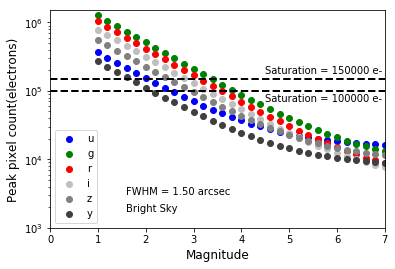

In [27]:
d_plot_zp_bright = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float') # b for bright sky
fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    for m in range(31):
        mag = 1.0 + 0.2 * m
        mags.append(mag)
        #for a source of mag, how many electrons is produced on detector in a second?
        ne = 10**((m5.Zp_t[f] - mag)/2.5)
        # what about dt seconds
        ne *= dt
        # how many fall into the center pixel? on top of the background and others
        npeak = ne*pRatio+ skyCounts[f]+bias_offset_subtract
        npeaks.append(npeak)
        d_plot_zp_bright.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
        if mag==5.0:
            peak_e_mag_5.append(npeak)
            print('for 5th mag, under bright sky, band %s, peak e per pixel = %.0f'%(f,npeak))
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
plt.plot([0,7.0],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([0,7.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.24, "FWHM = %.2f arcsec"%fwhm, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.18, "Bright Sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(0,7.0)
plt.ylim(1e3, 1.5e6)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12)
plt.savefig('Peak_count_by_band_trail_brightSky.pdf')

In [28]:
d_plot_zp_bright - d_plot_zp

,SatLimFromPlot
u,0.2
g,0.0
r,0.0
i,0.0
z,0.0
y,0.0
